# Test Unfold 5D
<hr style="border-top-width: 4px; border-top-color: #34609b;">
Version 17.0 example for multi-dimensional unfolding




**Author:** Stefan Schmitt, DESY  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Thursday, January 19, 2017 at 04:37 PM.</small></i>

In [1]:
%%cpp -d
#include <iostream>
#include <cmath>
#include <map>
#include <TMath.h>
#include <TCanvas.h>
#include <TStyle.h>
#include <TGraph.h>
#include <TFile.h>
#include <TH1.h>
#include "TUnfoldDensity.h"

using namespace std;

 #define PRINT_MATRIX_L

In [2]:
  // switch on histogram errors
  TH1::SetDefaultSumw2();

  //==============================================
  // step 1 : open output file
  TFile *outputFile=new TFile("testUnfold5_results.root","recreate");

  //==============================================
  // step 2 : read binning schemes and input histograms
  TFile *inputFile=new TFile("testUnfold5_histograms.root");

  outputFile->cd();

  TUnfoldBinning *detectorBinning,*generatorBinning;

  inputFile->GetObject("detector",detectorBinning);
  inputFile->GetObject("generator",generatorBinning);

  if((!detectorBinning)||(!generatorBinning)) {
  cout<<"problem to read binning schemes\n";
  }

  // save binning schemes to output file
  detectorBinning->Write();
  generatorBinning->Write();

  // read histograms
  TH1 *histDataReco,*histDataTruth;
  TH2 *histMCGenRec;

  inputFile->GetObject("histDataReco",histDataReco);
  inputFile->GetObject("histDataTruth",histDataTruth);
  inputFile->GetObject("histMCGenRec",histMCGenRec);

  histDataReco->Write();
  histDataTruth->Write();
  histMCGenRec->Write();

  if((!histDataReco)||(!histDataTruth)||(!histMCGenRec)) {
  cout<<"problem to read input histograms\n";
  }

  //========================
  // Step 3: unfolding

 // preserve the area
  TUnfold::EConstraint constraintMode= TUnfold::kEConstraintArea;

  // basic choice of regularisation scheme:
  //    curvature (second derivative)
  TUnfold::ERegMode regMode = TUnfold::kRegModeCurvature;

  // density flags
  TUnfoldDensity::EDensityMode densityFlags=
 TUnfoldDensity::kDensityModeBinWidth;

  // detailed steering for regularisation
  const char *REGULARISATION_DISTRIBUTION=0;
  const char *REGULARISATION_AXISSTEERING="*[B]";

  // set up matrix of migrations
  TUnfoldDensity unfold(histMCGenRec,TUnfold::kHistMapOutputHoriz,
                     regMode,constraintMode,densityFlags,
                     generatorBinning,detectorBinning,
                     REGULARISATION_DISTRIBUTION,
                     REGULARISATION_AXISSTEERING);

  // define the input vector (the measured data distribution)
  unfold.SetInput(histDataReco /* ,0.0,1.0 */);

  // print matrix of regularisation conditions
#ifdef PRINT_MATRIX_L
  TH2 *histL= unfold.GetL("L");
  for(Int_t j=1;j<=histL->GetNbinsY();j++) {
  cout<<"L["<<unfold.GetLBinning()->GetBinName(j)<<"]";
  for(Int_t i=1;i<=histL->GetNbinsX();i++) {
     Double_t c=histL->GetBinContent(i,j);
     if(c!=0.0) cout<<" ["<<i<<"]="<<c;
  }
  cout<<"\n";
  }
#endif
  // run the unfolding
  //
  // here, tau is determined by scanning the global correlation coefficients

  Int_t nScan=30;
  TSpline *rhoLogTau=0;
  TGraph *lCurve=0;

  // for determining tau, scan the correlation coefficients
  // correlation coefficients may be probed for all distributions
  // or only for selected distributions
  // underflow/overflow bins may be included/excluded
  //
  const char *SCAN_DISTRIBUTION="signal";
  const char *SCAN_AXISSTEERING=0;

  Int_t iBest=unfold.ScanTau(nScan,0.,0.,&rhoLogTau,
                          TUnfoldDensity::kEScanTauRhoMax,
                          SCAN_DISTRIBUTION,SCAN_AXISSTEERING,
                          &lCurve);

  // create graphs with one point to visualize best choice of tau
  Double_t t[1],rho[1],x[1],y[1];
  rhoLogTau->GetKnot(iBest,t[0],rho[0]);
  lCurve->GetPoint(iBest,x[0],y[0]);
  TGraph *bestRhoLogTau=new TGraph(1,t,rho);
  TGraph *bestLCurve=new TGraph(1,x,y);
  Double_t *tAll=new Double_t[nScan],*rhoAll=new Double_t[nScan];
  for(Int_t i=0;i<nScan;i++) {
  rhoLogTau->GetKnot(i,tAll[i],rhoAll[i]);
  }
  TGraph *knots=new TGraph(nScan,tAll,rhoAll);

  cout<<"chi**2="<<unfold.GetChi2A()<<"+"<<unfold.GetChi2L()
   <<" / "<<unfold.GetNdf()<<"\n";


  //===========================
  // Step 4: retreive and plot unfolding results

  // get unfolding output
  TH1 *histDataUnfold=unfold.GetOutput("unfolded signal",0,0,0,kFALSE);
  // get MOnte Carlo reconstructed data
  TH1 *histMCReco=histMCGenRec->ProjectionY("histMCReco",0,-1,"e");
  TH1 *histMCTruth=histMCGenRec->ProjectionX("histMCTruth",0,-1,"e");
  Double_t scaleFactor=histDataTruth->GetSumOfWeights()/
  histMCTruth->GetSumOfWeights();
  histMCReco->Scale(scaleFactor);
  histMCTruth->Scale(scaleFactor);
  // get matrix of probabilities
  TH2 *histProbability=unfold.GetProbabilityMatrix("histProbability");
  // get global correlation coefficients
  TH1 *histGlobalCorr=unfold.GetRhoItotal("histGlobalCorr",0,0,0,kFALSE);
  TH1 *histGlobalCorrScan=unfold.GetRhoItotal
  ("histGlobalCorrScan",0,SCAN_DISTRIBUTION,SCAN_AXISSTEERING,kFALSE);
  TH2 *histCorrCoeff=unfold.GetRhoIJtotal("histCorrCoeff",0,0,0,kFALSE);

  TCanvas *canvas = new TCanvas();
  canvas->Print("testUnfold5.ps[");

  //========== page 1 ============
  // unfolding control plots
  // input, matrix, output
  // tau-scan, global correlations, correlation coefficients
  canvas->Clear();
  canvas->Divide(3,2);

  // (1) all bins, compare to original MC distribution
  canvas->cd(1);
  histDataReco->SetMinimum(0.0);
  histDataReco->Draw("E");
  histMCReco->SetLineColor(kBlue);
  histMCReco->Draw("SAME HIST");
  // (2) matrix of probabilities
  canvas->cd(2);
  histProbability->Draw("BOX");
  // (3) unfolded data, data truth, MC truth
  canvas->cd(3);
  gPad->SetLogy();
  histDataUnfold->Draw("E");
  histDataTruth->SetLineColor(kBlue);
  histDataTruth->Draw("SAME HIST");
  histMCTruth->SetLineColor(kRed);
  histMCTruth->Draw("SAME HIST");
  // (4) scan of correlation vs tau
  canvas->cd(4);
  rhoLogTau->Draw();
  knots->Draw("*");
  bestRhoLogTau->SetMarkerColor(kRed);
  bestRhoLogTau->Draw("*");
  // (5) global correlation coefficients for the distributions
  //     used during the scan
  canvas->cd(5);
  //histCorrCoeff->Draw("BOX");
  histGlobalCorrScan->Draw("HIST");
  // (6) L-curve
  canvas->cd(6);
  lCurve->Draw("AL");
  bestLCurve->SetMarkerColor(kRed);
  bestLCurve->Draw("*");


  canvas->Print("testUnfold5.ps");

  canvas->Print("testUnfold5.ps]");

Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 360 input bins and 115 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #116
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing generator regMode=3 densityMode=1 axisSteering=*[B]
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing signal regMode=3 densityMode=1 axisSteering=*[B]
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing background regMode=3 densityMode=1 axisSteering=*[B]


Warning in <TUnfoldDensity::SetInput>: 31/360 input bins have zero error, and are ignored.
Info in <TUnfoldDensity::ScanTau>: logtau=-Infinity y=0.280098 X=2.437281 Y=9.205670


Info in <TUnfoldDensity::ScanTau>: logtau=-3.351901 y=0.431045 X=2.534001 Y=8.594646


Info in <TUnfoldDensity::ScanTay>: logtau=-3.851901 y=0.240404 X=2.442627 Y=9.088861


Info in <TUnfoldDensity::ScanTay>: logtau=-4.351901 y=0.275174 X=2.437357 Y=9.192271


Info in <TUnfoldDensity::ScanTay>: logtau=-4.851901 y=0.279594 X=2.437282 Y=9.204309


Info in <TUnfoldDensity::ScanTau>: logtau=-4.601901 y=0.278513 X=2.437289 Y=9.201383
Info in <TUnfoldDensity::ScanTau>: logtau=-4.101901 y=0.265364 X=2.437973 Y=9.164789


Info in <TUnfoldDensity::ScanTau>: logtau=-3.601901 y=0.224804 X=2.466248 Y=8.914801


Info in <TUnfoldDensity::ScanTau>: logtau=-4.726901 y=0.279203 X=2.437284 Y=9.203253


Info in <TUnfoldDensity::ScanTau>: logtau=-4.476901 y=0.277297 X=2.437306 Y=9.198078


Info in <TUnfoldDensity::ScanTau>: logtau=-4.226901 y=0.271517 X=2.437513 Y=9.182153
Info in <TUnfoldDensity::ScanTau>: logtau=-3.976901 y=0.255424 X=2.439265 Y=9.135715


Info in <TUnfoldDensity::ScanTau>: logtau=-3.726901 y=0.229158 X=2.450452 Y=9.017314


Info in <TUnfoldDensity::ScanTau>: logtau=-3.476901 y=0.316234 X=2.493530 Y=8.776066


Info in <TUnfoldDensity::ScanTau>: logtau=-4.789401 y=0.279426 X=2.437283 Y=9.203856
Info in <TUnfoldDensity::ScanTau>: logtau=-4.664401 y=0.278907 X=2.437286 Y=9.202450


Info in <TUnfoldDensity::ScanTau>: logtau=-4.539401 y=0.277990 X=2.437295 Y=9.199963


Info in <TUnfoldDensity::ScanTau>: logtau=-4.414401 y=0.276381 X=2.437324 Y=9.195579


Info in <TUnfoldDensity::ScanTau>: logtau=-4.289401 y=0.273589 X=2.437414 Y=9.187903


Info in <TUnfoldDensity::ScanTau>: logtau=-4.164401 y=0.268827 X=2.437683 Y=9.174617
Info in <TUnfoldDensity::ScanTau>: logtau=-4.039401 y=0.260956 X=2.438460 Y=9.152061


Info in <TUnfoldDensity::ScanTau>: logtau=-3.914401 y=0.248609 X=2.440569 Y=9.114939


Info in <TUnfoldDensity::ScanTau>: logtau=-3.789401 y=0.233716 X=2.445781 Y=9.056598


Info in <TUnfoldDensity::ScanTau>: logtau=-3.414401 y=0.372699 X=2.512137 Y=8.691208


Info in <TUnfoldDensity::ScanTau>: logtau=-3.664401 y=0.223632 X=2.457114 Y=8.970264
Info in <TUnfoldDensity::ScanTau>: logtau=-3.539401 y=0.265592 X=2.478281 Y=8.850302


Info in <TUnfoldDensity::ScanTau>: logtau=-4.820651 y=0.279516 X=2.437282 Y=9.204099


Info in <TUnfoldDensity::ScanTau>: logtau=-4.758151 y=0.279323 X=2.437283 Y=9.203576


Info in <TUnfoldDensity::ScanTau>: logtau=-4.695651 y=0.279066 X=2.437285 Y=9.202880


chi**2=289.624+47.9755 / 213


Info in <TUnfoldDensity::ScanTau>: logtau=-4.633151 y=0.278724 X=2.437287 Y=9.201954
Info in <TUnfoldDensity::ScanTau>: Result logtau=-3.629816 y=0.220136 X=2.461834 Y=8.940652


Info in <TCanvas::Print>: ps file testUnfold5.ps has been created


Info in <TCanvas::Print>: Current canvas added to ps file testUnfold5.ps
Info in <TCanvas::Print>: ps file testUnfold5.ps has been closed


Draw all canvases 

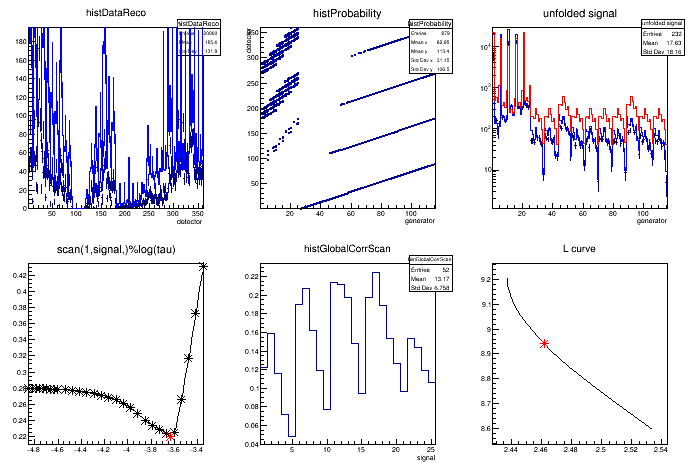

In [3]:
gROOT->GetListOfCanvases()->Draw()